# Python Assignment

## Script for Sequence Translating Penguin Data for Dr.X

This script is used for processing and visualizing data for 12 penguin species. More specifically, cytochrome-b sequencing data will be translated and used to compute simple summaries to visualize data.

Part of this script was created in part by Dr. X.

Make sure to upload all data to the data folder before running.

## Libraries/Installations

In [1]:
# IMPORTANT: install BioPython for script to be functional

from Bio import SeqIO
from Bio.Data import CodonTable
import os
import pandas as pd

## Functions

In [2]:
# Assigns sequences with the species name to a dictionary variable
def get_sequences_from_file(fasta_fn):
    sequence_data_dict = {}
    for record in SeqIO.parse(fasta_fn, "fasta"):
        
        #Splits the description line of the fasta file (starting with ">")
        description = record.description.split()
        
        # Assigns the species name to a variable
        species_name = description[1] + " " + description[2]
        
        #Adds the species name and FASTA sequence to the dictionary variable
        sequence_data_dict[species_name] = record.seq
        
    #Returns the created dictionary
    return(sequence_data_dict)

In [3]:
#Translate a nucleotide sequence into an amino acid sequence
def translate_sequence(string_nucleotides):
    #Creates a BioPython object that holds amino acid code for Vertebrate Mitochondria
    mito_table = CodonTable.unambiguous_dna_by_name["Vertebrate Mitochondrial"]
    aa_sequence_string = ""
    
    #Iterates over the nucleotide sequence in steps of 3
    for i in range(0, len(string_nucleotides) - 2, 3):
        
        #Assigns three nucleotides to the codon variable
        codon = string_nucleotides[i:i+3]
        
        #Breaks loop if a stop codon is found, leaving it out of the returned aa sequence
        if codon in mito_table.stop_codons:
            break
            
        #Uses the codon table method to search the dictionary mito_table for the codon that matches the current
        #sequence and adds it to the aa_sequence_string
        aa = mito_table.forward_table[codon]
        aa_sequence_string += aa
        
    return(aa_sequence_string)

In [4]:
#Seperate function to translate the nucleotide sequence into an amino acid sequence using the Seq module from BioPython
from Bio.Seq import Seq
def alternative_translation(string_nucleotides):
    
    #Assigns the nucleotide sequence to an object in BioPython that is used for sequence manipulation
    seq = Seq(string_nucleotides)
    
    #Uses the translate method to obtain the aa sequence
    aa_seq = seq.translate(table = "Vertebrate Mitochondrial", to_stop = True)
    
    #Changes the variable type from Seq object to string
    aa_seq_string = str(aa_seq)
    
    return(aa_seq_string)
    

In [5]:
#Calculates the molecular weight for each amino acid sequence using the ProtPram BioPython Module
from Bio.SeqUtils.ProtParam import ProteinAnalysis
def compute_molecular_weight(aa_seq):
   
    #Ensures that the aa_seq variable is a str
    aa_seq_string = str(aa_seq)
    
    #Uses the Protein_Analysis function to convert the string into a Seq object for the ProtPram module
    analyzed_aa_seq = ProteinAnalysis(aa_seq_string)
    
    #Calculates the molecular weight of the aa string
    molecular_weight = analyzed_aa_seq.molecular_weight()
    
    return(molecular_weight)
    

In [6]:
#Calculates GC% content using the ProtPram BioPython Module
def gc_content(seq):
    
    #Assigns the nucleotide sequence to an object in BioPython that is used for sequence manipulation
    new_seq = Seq(seq)
    
    #Uses the .count method from the Seq object to count the number of Gs and Cs
    gc_count = new_seq.count("G") + new_seq.count("C")
    
    #Calculates the GC%
    gc_percent = (gc_count / len(new_seq)) * 100
    
    
    return(gc_percent)
    

# Main

In [7]:
#Assigns current working directory to a string along with location of data
wd = os.getcwd() + "/data/penguins_cytb.fasta"

#Reads the fasta file into a dictionary
cytb_seqs = get_sequences_from_file(wd) 

#Assigns current working directory to a string along with location of data
wd = os.getcwd() + "/data/penguins_mass.csv"

#Inputing penguin data into a dataframe
penguins_df = pd.read_csv(wd) # Includes only data for body mass 
species_list = list(penguins_df.species)

### Adding Molecular Weight and GC% to the Penguins Dataframe

(Could create as dataframes instead to ensure proper line up of data)

In [8]:
#Creating empty columns in the penguins_df to add molecular weight and GC% content data to later
penguins_df["molecular weight"] = None
penguins_df["GC%"] = None

In [9]:
#Adding data to the empty columns using user defined functions
for species, sequence in cytb_seqs.items():
    
    #Iterates over each species and uses the gc_content function to calculate GC% for each sequence
    species_gc_content = (gc_content(sequence))
    
    #Converts nucleotide sequence into amino acid sequence using the alternative_translation function
    aa_sequence = alternative_translation(sequence)
    
    #Iterates over each species and uses the compute_molecular_weight function to calculate molecular weight for each sequence
    species_molecular_weight = (compute_molecular_weight(aa_sequence))
    
    #Adds molecular weight and GC% to the correct location in the dataframe using species as a key
    penguins_df.loc[penguins_df["species"] == species, "GC%"] = species_gc_content
    penguins_df.loc[penguins_df["species"] == species, "molecular weight"] = species_molecular_weight



### Visualizing Species Mass

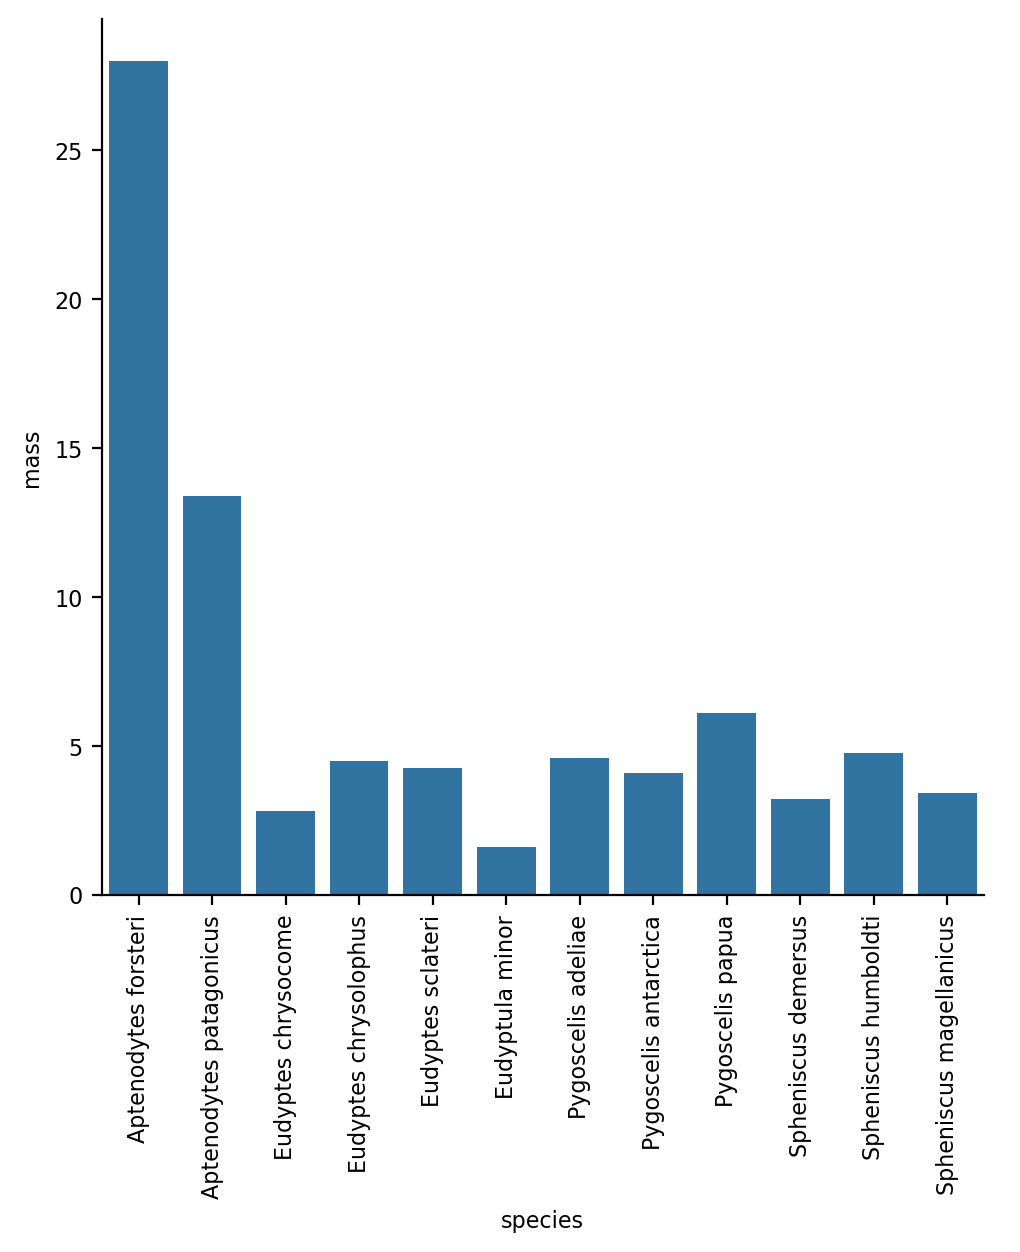

In [10]:
#Importing the necessary modules for plotting
import seaborn as sns
import matplotlib.pyplot as plt


#Changing default settings to make the plots more astetically pleasing
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams.update({'font.size': 8})

#Plots species vs mass and tilts the x axis labels so all data fits on the bar graph
sns.catplot(data=penguins_df, x='species', y='mass', kind='bar');
plt.xticks(rotation=90);

### What is the smallest penguin species?
   *Eudyptula minor*

### What is the geographical range of this species?
   *Eudyptula minor can be found along the southern coast of Australia, as far north as the South Solitary Island off the coast of New South Wales, and are also natives to the coasts of New Zeland according to https://animaldiversity.org/accounts/Eudyptula_minor/.*

### Visualizing GC% vs Molecular Weight

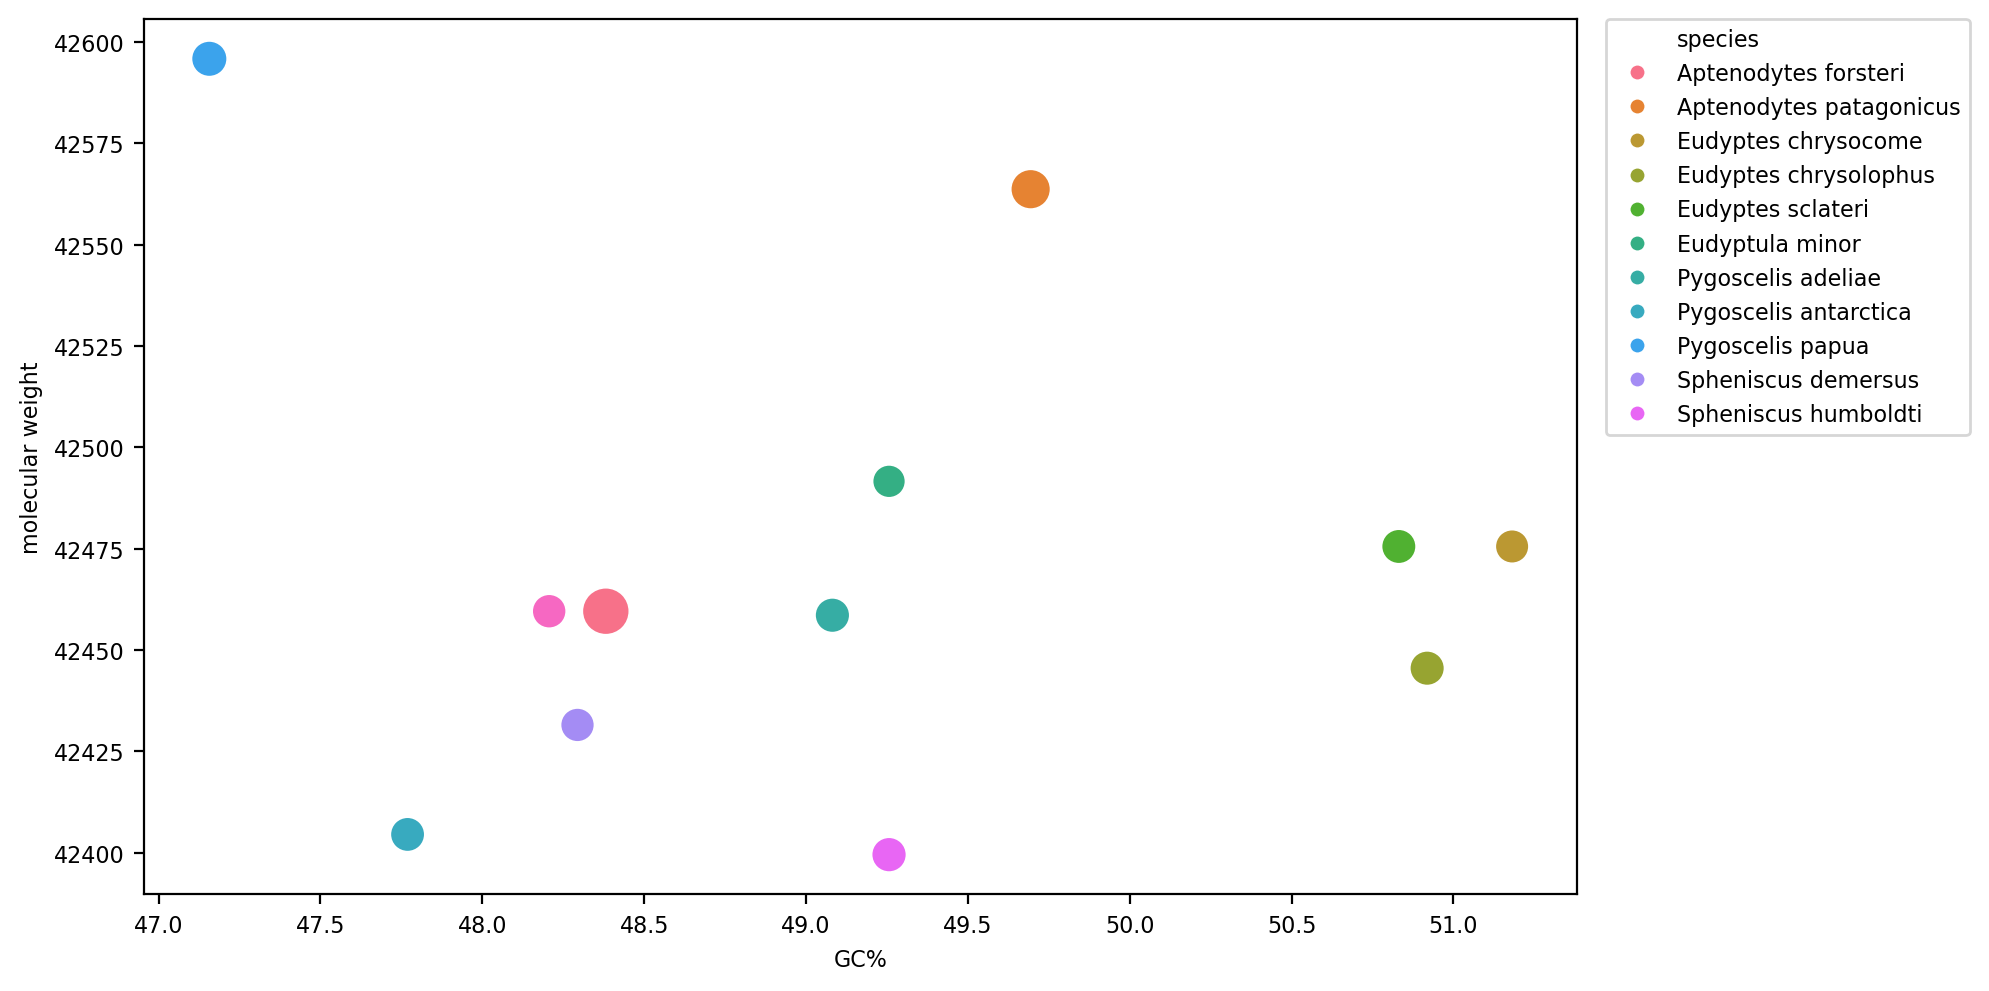

In [11]:
#Creating a scatterplot because the variables are relational to one another and assigning the size of the dots to mass for some
#extra fun
ax = sns.scatterplot(data=penguins_df, x="GC%", y="molecular weight", hue="species", size = "mass",  sizes=(150, 300), 
                legend = 'brief')

#Initializing handles and labels variables to assign a special legend to the graph
handles, labels = ax.get_legend_handles_labels()

#Retrieves the unique species names in order to create a legend that does not include mass keys. Also moves the legend to the 
#left corner instead of over the graph
plt.legend(handles[:len(penguins_df["species"].unique())], labels[:len(penguins_df["species"].unique())],
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#Resizes and displays the plot
plt.tight_layout() 
plt.show()

# Output

In [13]:
#Outputs the penguins dataframe to a comma delimited file
wd = os.getcwd() + "/results/penguins_mass_cytb.csv"
penguins_df.to_csv(wd)

# BONUS

*What else can be done with this dataset?*

I'd like to examine the amino acid usage across species

In [17]:
#Importing module from the collections library to count amino acids in a string
from collections import Counter

#Initializing an empty dictionary for aa counts
aa_frequency = {}

for species, sequence in cytb_seqs.items():
    
    #Converts nucleotide sequence into amino acid sequence using the alternative_translation function
    aa_sequence = alternative_translation(sequence)
    
    #Uses a Counter object that is similar to a dictionary to count each AA in the seq
    aa_counts = Counter(aa_sequence)
    
    #Calculates the relative frequency of each AA
    aa_frequency[species] = aa_freq = {aa: count / len(aa_sequence) for aa, count in aa_counts.items()}
    

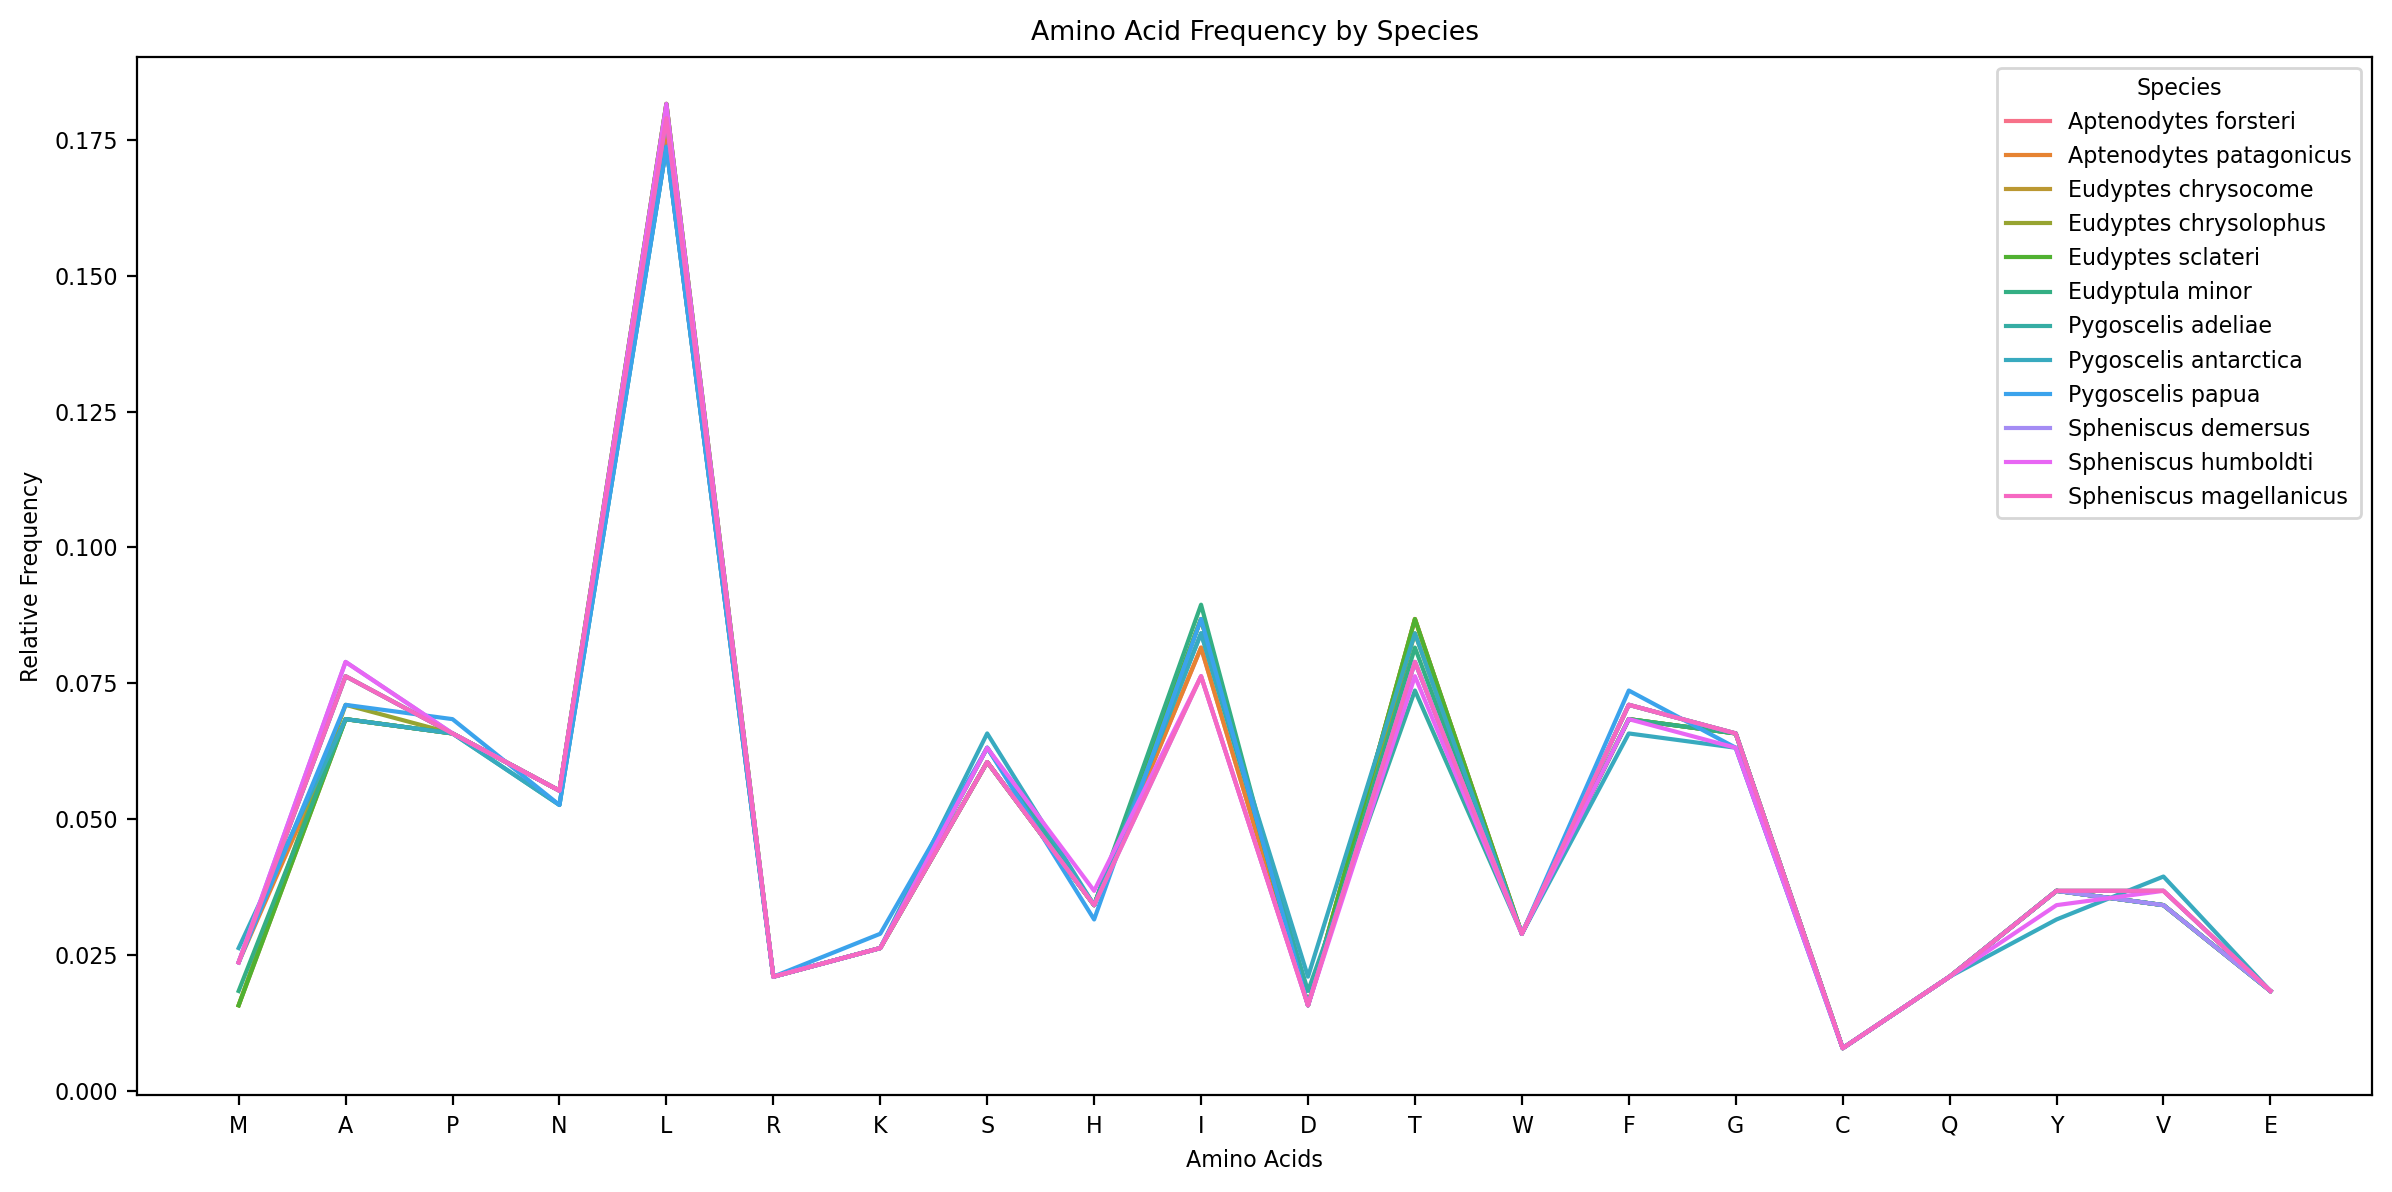

In [26]:
aa_freq_df = pd.DataFrame.from_dict(aa_frequency, orient='index')

# Converts our data from wide to long format
melted_df = aa_freq_df.reset_index().melt(id_vars='index', var_name='Amino Acid', value_name='Frequency')
melted_df = melted_df.rename(columns={'index': 'Species'})

# Plots the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Amino Acid', y='Frequency', hue='Species')

plt.title('Amino Acid Frequency by Species')
plt.ylabel('Relative Frequency')
plt.xlabel('Amino Acids')
plt.tight_layout()
plt.show()

As it turns out, all the species have releatively the same amino acid frequency!